In [2]:
# Library imports
import numpy as np                        
import pandas as pd                     
import matplotlib.pyplot as plt          
import seaborn as sns                    


In [3]:
# EMA import and Sensitivity Analysis specific import
from ema_workbench import (              
    Samplers,                           
    Policy,                              
    ema_logging,                         
    SequentialEvaluator,                 
    save_results                         
)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem  
from SALib.analyze import sobol          

# Local modules
from dike_model_function import DikeNetwork            
from problem_formulation import get_model_for_problem_formulation  

import copy     

In [4]:
# Enable logging to monitor EMA Workbench execution
ema_logging.log_to_stderr(ema_logging.INFO)  

<Logger EMA (DEBUG)>

In [5]:
# Load the model based on a specific policy scenario (formulation 1)
model, steps = get_model_for_problem_formulation(1)
  
# Deep copy uncertainties and levers for manipulation
model_uncertainties = copy.deepcopy(model.uncertainties)  
model_levers = copy.deepcopy(model.levers)
  

In [6]:
  # Set up a baseline policy with all levers set to zero (do nothing)
zero_lever_config = {lever.name: 0 for lever in model_levers}   
baseline_policy = Policy("No Action", **zero_lever_config)
  

In [7]:
  # Perform Sobol sampling experiments with the defined zero-policy
n_samples = 10 # change to 40000 for full Sobol experiment
  
with SequentialEvaluator(model) as evaluator:                      
    input_scenarios, model_outputs = evaluator.perform_experiments( 
        scenarios=n_samples,
        policies=[baseline_policy],
        uncertainty_sampling=Samplers.SOBOL                     
    )

/Users/douweeijssen/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 400 scenarios * 1 policies * 1 model(s) = 400 experiments
100%|████████████████████████████████████████| 400/400 [03:07<00:00,  2.13it/s]
[MainProcess/INFO] experiments finished


In [8]:
  # Save results for future reuse
save_results((input_scenarios, model_outputs), 'results_sequential.tar.gz') 
  

[MainProcess/INFO] results saved successfully to /Users/douweeijssen/final_assignment/final assignment/results_sequential.tar.gz


In [9]:
  # Construct SALib problem definition from uncertainties
salib_problem = get_SALib_problem(model_uncertainties)
  
  # Perform Sobol sensitivity analysis on key outcome indicators
def perform_sobol_analysis(metric_name):                
    outcome_data = model_outputs[metric_name]           
    return sobol.analyze(                               
        salib_problem,
        outcome_data,
        calc_second_order=True,
        print_to_console=True
    )

sobol_damage = perform_sobol_analysis('Expected Annual Damage')
sobol_deaths = perform_sobol_analysis('Expected Number of Deaths')
sobol_costs = perform_sobol_analysis('Total Investment Costs')
  

/Users/douweeijssen/opt/anaconda3/lib/python3.9/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/douweeijssen/opt/anaconda3/lib/python3.9/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                                   ST       ST_conf
A.0_ID flood wave shape  3.713142e-04  3.479831e-04
A.1_Bmax                 3.510452e-04  7.597009e-04
A.1_Brate                8.080798e-08  1.752011e-07
A.1_pfail                1.421739e+00  8.329156e-01
A.2_Bmax                 6.368676e-06  1.353773e-05
A.2_Brate                4.103003e-06  9.181648e-06
A.2_pfail                5.964028e-02  7.639217e-02
A.3_Bmax                 2.166557e-05  3.893671e-05
A.3_Brate                1.046750e-07  2.238167e-07
A.3_pfail                3.594793e-01  3.737118e-01
A.4_Bmax                 0.000000e+00  0.000000e+00
A.4_Brate                0.000000e+00  0.000000e+00
A.4_pfail                2.599355e-04  4.412069e-04
A.5_Bmax                 0.000000e+00  0.000000e+00
A.5_Brate                0.000000e+00  0.000000e+00
A.5_pfail                1.213338e-02  2.319977e-02
discount rate 0          3.375159e-02  2.109717e-02
discount rate 1          4.531656e-02  3.767981e-02
discount rat

/Users/douweeijssen/opt/anaconda3/lib/python3.9/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/douweeijssen/opt/anaconda3/lib/python3.9/site-packages/SALib/analyze/sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


In [10]:
  # Helper function to convert Sobol results to tidy DataFrame
def format_sobol_indices(sobol_result):                            
    selected_keys = ['S1', 'S1_conf', 'ST', 'ST_conf']            
    sobol_df = pd.DataFrame({key: sobol_result[key] for key in selected_keys},  
                             index=salib_problem['names'])       
    return sobol_df.sort_values(by='ST', ascending=False) 
  

In [11]:
  # Plotting function for a single metric

def plot_sobol(df, title_text, ylabel_text):                       
    fig, ax = plt.subplots(figsize=(10, 6))                        
    df[['S1', 'ST']].plot.bar(ax=ax, yerr=df[['S1_conf', 'ST_conf']].T.values, capsize=4)  
    ax.set_title(title_text, fontweight='bold')                 
    ax.set_ylabel(ylabel_text)                                    
    ax.set_xlabel('Model Uncertainties')                          
    ax.legend(['First-order (S1)', 'Total-order (ST)'])           
    plt.xticks(rotation=45, ha='right')                           
    plt.tight_layout()                                            
    sns.despine()                                                 
    plt.show()  
  

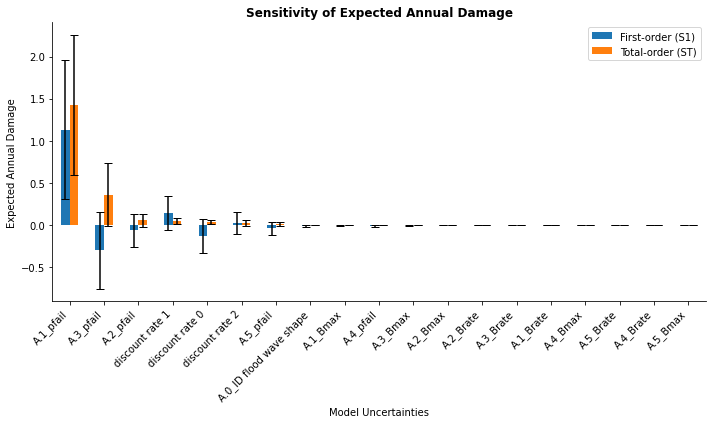

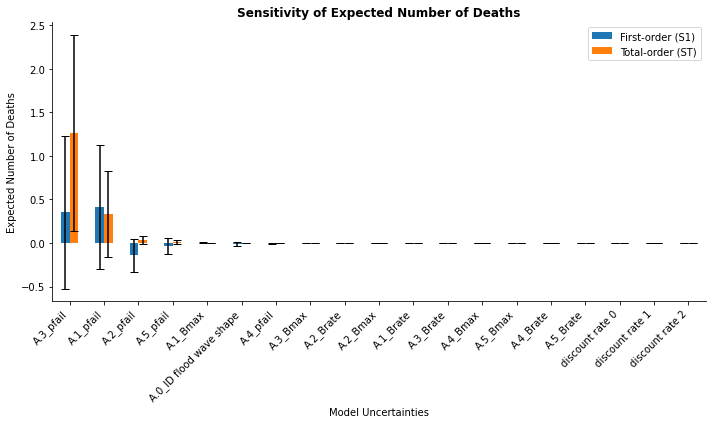

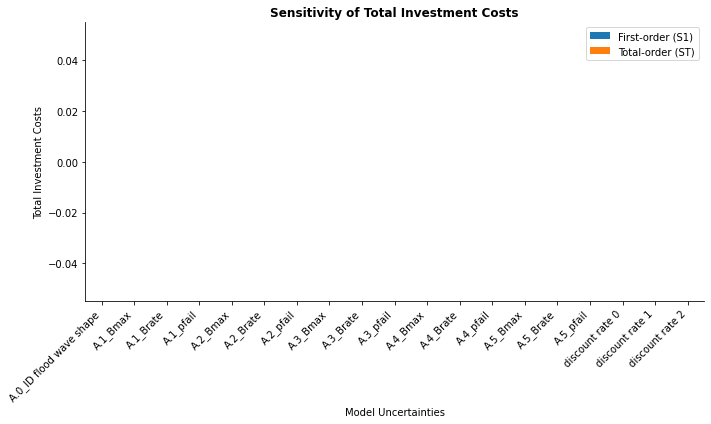

In [12]:
  # Apply plotting to each sensitivity analysis
plot_sobol(format_sobol_indices(sobol_damage),
           'Sensitivity of Expected Annual Damage',
           'Expected Annual Damage')

plot_sobol(format_sobol_indices(sobol_deaths),
           'Sensitivity of Expected Number of Deaths',
           'Expected Number of Deaths')

plot_sobol(format_sobol_indices(sobol_costs),
           'Sensitivity of Total Investment Costs',
           'Total Investment Costs')
  

In [13]:
  # (Optional) Print one output as raw array if needed
print(model_outputs['Total Investment Costs']) 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.